# Inversion example of diffusion inversion in 2d

- Importation of the required modules

In [1]:
import copy
import os
from pathlib import Path

import gstools as gs
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from matplotlib.colors import LogNorm
from pyrtid import ForwardModel, InversionExecutor, __version__
from pyrtid.models import ForwardModel

In [2]:
print(f"pyrtid version = {__version__}")

pyrtid version = 0.1.0


- Define some configurations for the plots

In [3]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "animation.frame_format": "svg",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.rcParams.update(new_rc_params)

- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

## Forward problem

- Define a very simple pure diffusion case in 2D.

In [5]:
# System parameters
nx = 21  # number of voxels along the x axis
ny = 21  # number of voxels along the y axis
dx = 10.0  # voxel dimension along the x axis
dy = 10.0  # voxel dimension along the y axis
nt = 4000  # number of time steps
dt = 400.0  # timestep in seconds
# Hydro parameters
D0 = 1e-5  # general initial diffusion coefficient [m2/s]
k0 = 1e-5  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
M0 = 0.001  # mineral grade [mol/kg] -> kg of water
kv = -2.2e-9  # kinetic rate,       [mol/m2/s]
As = 13.5  # specific area,      [m2/mol]
Ks = 1.0 / pow(10, 3.2)  # solubility constant [no unit]
wdif = 1.0  # Diffusion
wadv = 0.0  # No avection
wmin = 1.0  # Mineral dissolution


# We define a function to easily generate a model.
def create_base_model() -> ForwardModel:
    return ForwardModel(
        nx,
        ny,
        dx,
        dy,
        nt,
        dt,
        c0,
        D0,
        k0,
        w0,
        M0,
        kv,
        As,
        Ks,
        wdif=wdif,
        wadv=wadv,
        wmin=wmin,
    )

- Create two models

In [6]:
model_reference = create_base_model()
model_estimate = create_base_model()

TypeError: __init__() got an unexpected keyword argument 'wdif'

The mineral grades are defined in [mol/kg]. We calculate the conversion factor to obtain ppm and perform easier mass balances.

ConvU: parameter for converting the mineral content in [mol/kg] to metal grade in [ppm]. Note that the ConvU parameter is specific to the Uranium carrier phase: here Uraninite.

$C_{Uraninite}[\frac{mol}{kg}] = convU * T_{Uranium}[ppm] / 1000$


and


$conv_u = \frac{1.023 * density_{rock}}{238*porosity_{rock}}$

Note the 1.023 is the conversion factor from molar mass to molal mass in CHESS.

We need to interpolate to go from a grid (nx-1, ny-1) of porosity to a grid (nx, ny) of mineral grades (this is due to finite differences inplementation).

In [ ]:
porosity = np.zeros((nx, ny))
porosity[1:-1, 1:-1] = (
    model_reference.w[:-1, :-1]
    + model_reference.w[1:, :-1]
    + model_reference.w[:-1, 1:]
    + model_reference.w[1:, 1:]
) / 4
porosity[0, :] = porosity[1, :]
porosity[-1, :] = porosity[-2, :]
porosity[:, 0] = porosity[:, 1]
porosity[:, -1] = porosity[:, -2]

conv_u: np.ndarray = 1.023 * 1.63 / (238.0 * porosity)

- Create an initial gaussian spatial distribution for the mineral

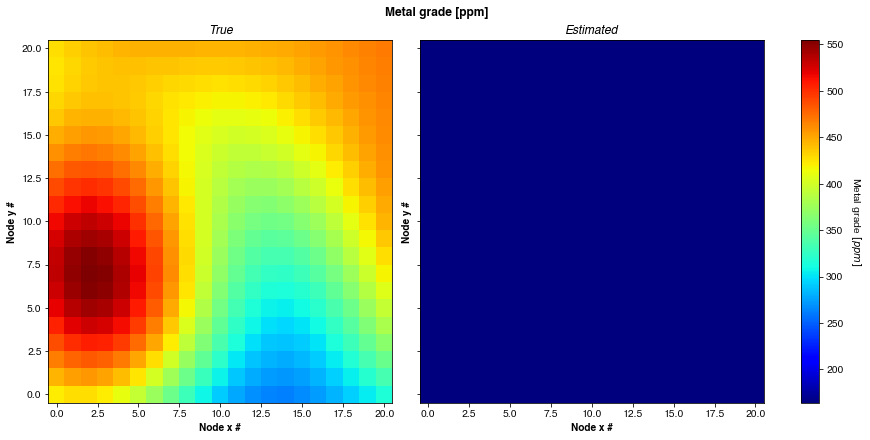

In [ ]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 194

min_val = 0.001
max_val = 0.02
# Compute the mean and the standard deviation that the distibution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2
stdev = (max_val - min_val) / 2 / 3  # std ~ 1/6 of the distribution interval
len_scale = 10

model_reference.s_init = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]


# Initial estimate = an homogenous value
model_estimate.s_init = np.ones((nx, ny)) * 0.005

plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 6)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)
plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2"],
    data={
        "True": model_reference.s_init / conv_u * 1000,
        "Estimated": model_estimate.s_init / conv_u * 1000,
    },
    cbar_title="Metal grade $[ppm]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet")},
    xlabel="Node x #",
    ylabel="Node y #",
)
plotter.subfigs["fig0"].suptitle("Metal grade [ppm]", fontweight="bold")

fname = "Diffusion_field_true_vs_estimated"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Run the two systems

In [ ]:
solver_true = ForwardModel(model_reference)
solver_true.solve()

solver_estimate = ForwardModel(model_estimate)
solver_estimate.solve()

We can disply the results in different ways.

Text(0.5, 0.98, 'Tracer concentration')

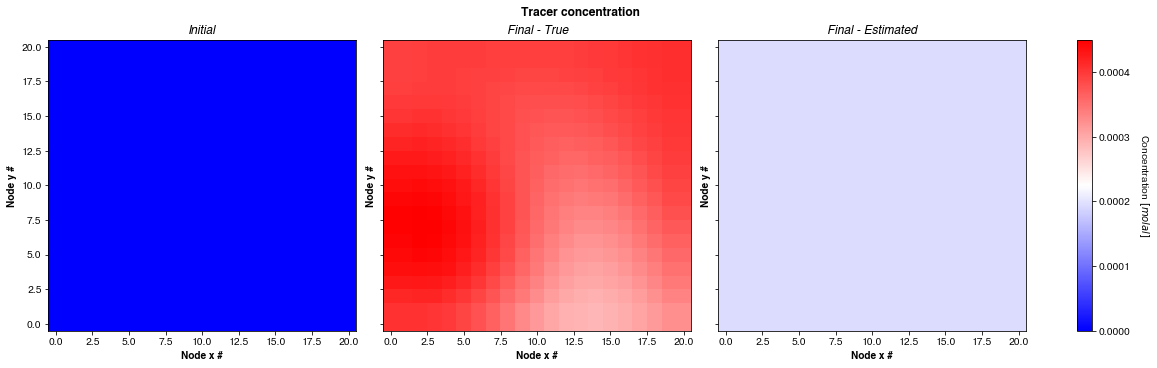

In [ ]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)
plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2", "ax1-3"],
    data={
        "Initial": model_reference.c_init,
        "Final - True": model_reference.tr_model.conc[:, :, -1],
        "Final - Estimated": model_estimate.tr_model.conc[:, :, -1],
    },
    cbar_title="Concentration $[molal]$",
    xlabel="Node x #",
    ylabel="Node y #",
)
plotter.subfigs["fig0"].suptitle("Tracer concentration", fontweight="bold")

In [ ]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)
nb_frames = 40
plotter.plot_2d_animated_field(
    ax_names=["ax1-1", "ax1-2"],
    data={
        "True concentration": model_reference.tr_model.conc[:nb_frames],
        "Estimated concentration": model_estimate.tr_model.conc[:nb_frames],
    },
    cbar_title="Concentration $[molal]$",
    xlabel="Node x #",
    ylabel="Node y #",
    nb_frames=nb_frames,
)
plotter.subfigs["fig0"].suptitle("Tracer concentration", fontweight="bold")
plt.close(plotter.fig)
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname = fig_save_path.joinpath("conc_2d_animation.html")
writer = HTMLWriter(fps=5)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname, writer=writer)
# plotter.animation.save(fname_gif, writer='pillow', fps=5)

# Display the animation
HTML(fname.read_text())

- Place observation wells

In [ ]:
# locations in the grid
obs_grid_locations = [(7, 7), (7, 13), (13, 7), (13, 13)]
# locations in the plots
obs_plot_locations = [(1, 2), (1, 1), (2, 1), (2, 2)]

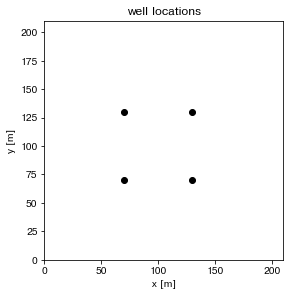

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
# TODO: create a specific plotter for that (support 1 & 2D)
for i, j in obs_grid_locations:
    plt.plot(i * model_reference.dx, j * model_reference.dy, "ko")
plt.xlim(0, model_reference.nx * model_reference.dx)
plt.ylim(0, model_reference.ny * model_reference.dy)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("well locations")
ax.set_aspect("equal", adjustable="box")
fname = "well_locations"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

([<matplotlib.lines.Line2D at 0x7fb65c4d85b0>,
 ['True', 'Initial estimation'])

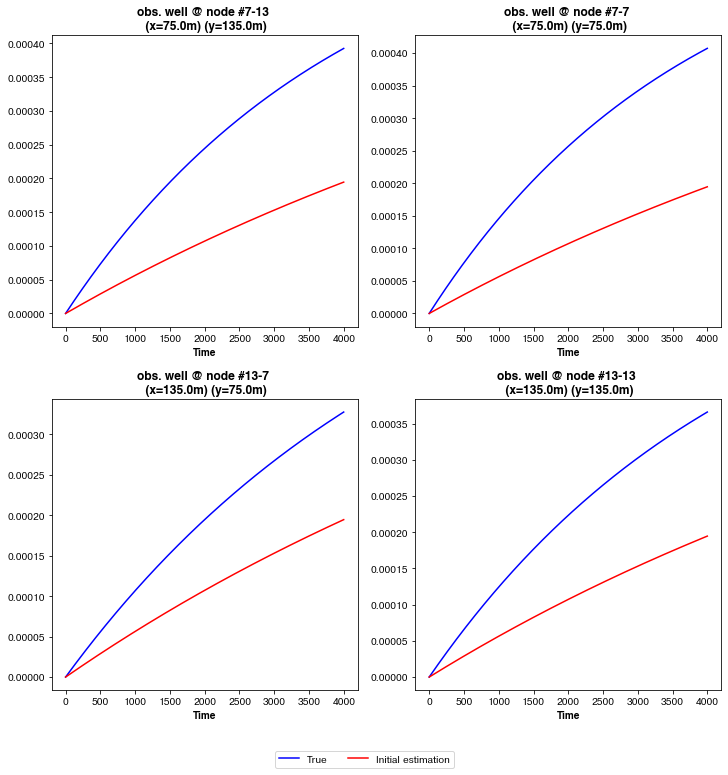

In [ ]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={
        "nrows": max([elt[0] for elt in obs_plot_locations]),
        "ncols": max([elt[1] for elt in obs_plot_locations]),
    },
)

# Static plot
for (ix, jx), (row_id, col_id) in zip(obs_grid_locations, obs_plot_locations):
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node #{ix}-{jx} \n (x={x}m) (y={y}m)"

    plotter.plot_1d_field(
        ax_name=f"ax{row_id}-{col_id}",
        title=obs_well_name,
        data={
            "True": {
                "data": model_reference.tr_model.conc[ix, jx, :],
                "kwargs": {"c": "b"},
            },
            "Initial estimation": {
                "data": model_estimate.tr_model.conc[ix, jx, :],
                "kwargs": {"c": "r"},
            },
        },
        xlabel="Time",
    )
plotter.add_fig_legend(ncol=2)

## Inversion

### Gradient verification with finite difference

Inversion with three wells. Let's first check if the gradient with ths adjoint state method is correct. Note that all solvers do not support bounds -> although it is useless here, we use a sqrt preconditionner to ensure positive values (just for the example). 

In [ ]:
# Create an executor
executor = InversionExecutor(copy.copy(model_estimate))


def sqrt_first_derivative(x: np.ndarray) -> np.ndarray:
    """Return 1/(2 * sqrt(x))."""
    return 1 / (2 * np.sqrt(x))


param = AdjustableParameter(
    name=ParameterName.INITIAL_GRADE,
    lbounds=1e-3,
    ubounds=2e-2,
    preconditioner=dminv.LogTransform(),
)

observables = {}
for ix, jx in obs_grid_locations:
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy

    vals = model_reference.tr_model.conc[ix, jx, :]
    timesteps = np.arange(vals.shape[0])

    observables[(ix, jx)] = Observable(
        state_variable="tracer",
        location=(slice(ix, ix + 1, 1), slice(jx, jx + 1, 1)),
        timesteps=timesteps,
        values=vals,
    )

is_grad_ok = executor.is_gradient_correct(
    param,
    list(observables.values()),
)
print("Is the gradient correct: ", is_grad_ok)

Is the gradient correct:  True


The gradient seems correct, let's plot it !

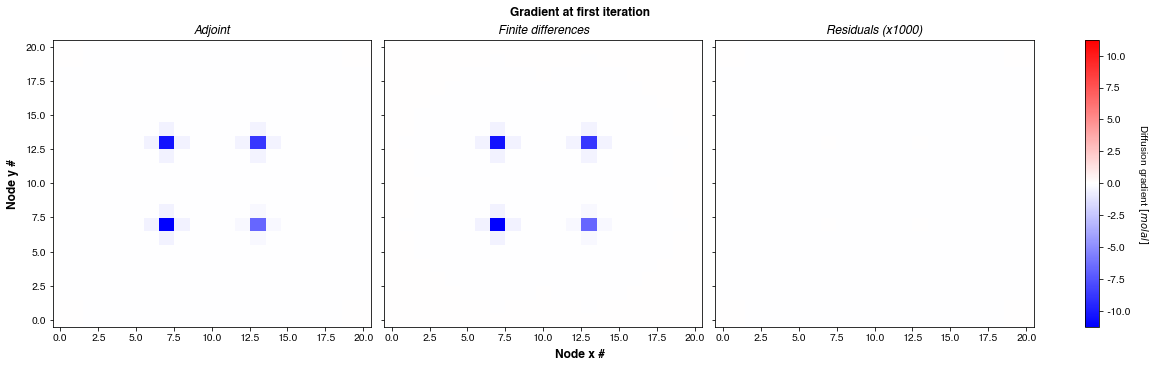

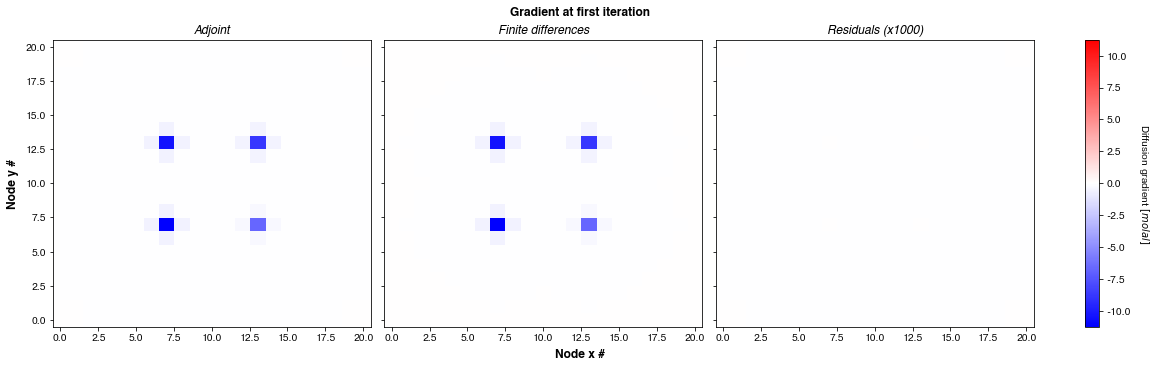

In [ ]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

adjoint_grad = executor.rt_solver.get_gridded_gradients(
    ParameterName.INITIAL_GRADE, is_adjoint=True
)[:, :, 0]
fd_grad = executor.rt_solver.get_gridded_gradients(
    ParameterName.INITIAL_GRADE, is_adjoint=False
)[:, :, 0]

plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2", "ax1-3"],
    data={
        "Adjoint": adjoint_grad,
        "Finite differences": fd_grad,
        "Residuals (x1000)": adjoint_grad - fd_grad,
    },
    cbar_title="Diffusion gradient $[molal]$",
    is_symmetric_cbar=True,
)
plotter.subfigs["fig0"].suptitle("Gradient at first iteration", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("Node x #", fontweight="bold")
plotter.subfigs["fig0"].supylabel("Node y #", fontweight="bold")

Plot of the adjoint variables

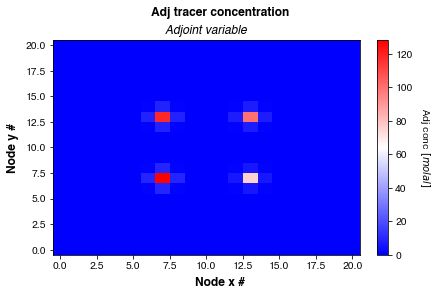

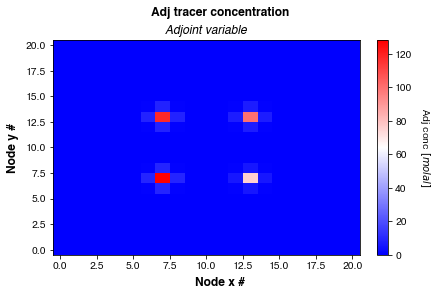

In [ ]:
plotter = FieldPlotter()
plotter.plot_2d_field(
    ax_names=["ax1-1"],
    data={
        "Adjoint variable": executor.rt_solver.inverse_model.adj_min[
            :, :, -3500
        ],  # adjoint variables are reversed in time
        # "Adjoint variable": np.flip(executor.rt_solver.inverse_model.adj_conc, axis=2), # adjoint variables are reversed in time
        # "Adjoint variable": executor.rt_solver.inverse_model.adj_conc[0, :, :], # adjoint variables are reversed in time
    },
    cbar_title="Adj conc $[molal]$",
    # Plot with a log scale
    # imshow_kwargs={"norm": LogNorm(vmin=executor.rt_solver.inverse_model.adj_conc.min(), vmax=executor.rt_solver.inverse_model.adj_conc.max())}
)
plotter.subfigs["fig1-1"].suptitle("Adj tracer concentration", fontweight="bold")
plotter.subfigs["fig1-1"].supxlabel("Node x #", fontweight="bold")
plotter.subfigs["fig1-1"].supylabel("Node y #", fontweight="bold")

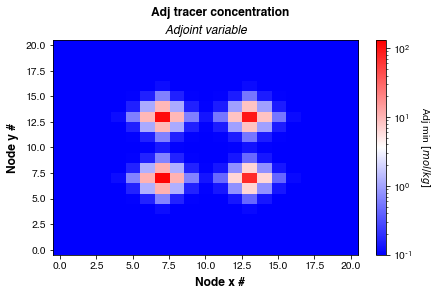

In [ ]:
plotter = FieldPlotter()
nb_frames = 30

# Set bad (see https://stackoverflow.com/questions/9455044/problems-with-zeros-in-matplotlib-colors-lognorm)
# my_cmap = copy.copy(mpl.cm.get_cmap("bwr")) # copy the default cmap
# my_cmap.set_bad((0, 0, 0))

data = (
    executor.rt_solver.inverse_model.adj_min[:, :, ::-1] + 1e-1
)  # to avoid zeros with a logscale
plotter.plot_2d_animated_field(
    ax_names=["ax1-1"],
    data={
        "Adjoint variable": data,  # adjoint variables are reversed in time
        # "Adjoint variable": np.flip(executor.rt_solver.inverse_model.adj_conc, axis=2), # adjoint variables are reversed in time
        # "Adjoint variable": executor.rt_solver.inverse_model.adj_conc[0, :, :], # adjoint variables are reversed in time
    },
    cbar_title="Adj min $[mol/kg]$",
    nb_frames=nb_frames,
    # Plot with a log scale
    imshow_kwargs={"norm": LogNorm(vmax=np.max(data))},
)
plotter.subfigs["fig1-1"].suptitle("Adj tracer concentration", fontweight="bold")
plotter.subfigs["fig1-1"].supxlabel("Node x #", fontweight="bold")
plotter.subfigs["fig1-1"].supylabel("Node y #", fontweight="bold")

plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname = fig_save_path.joinpath("adj_conc_2d_animation.html")
writer = HTMLWriter(fps=2)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname, writer=writer)
# plotter.animation.save(fname_gif, writer='pillow', fps=5)

# Display the animation
HTML(fname.read_text())

At the observatinon well, we can see that the sign of the adjoint variable globally depends on the sign of the residuals.

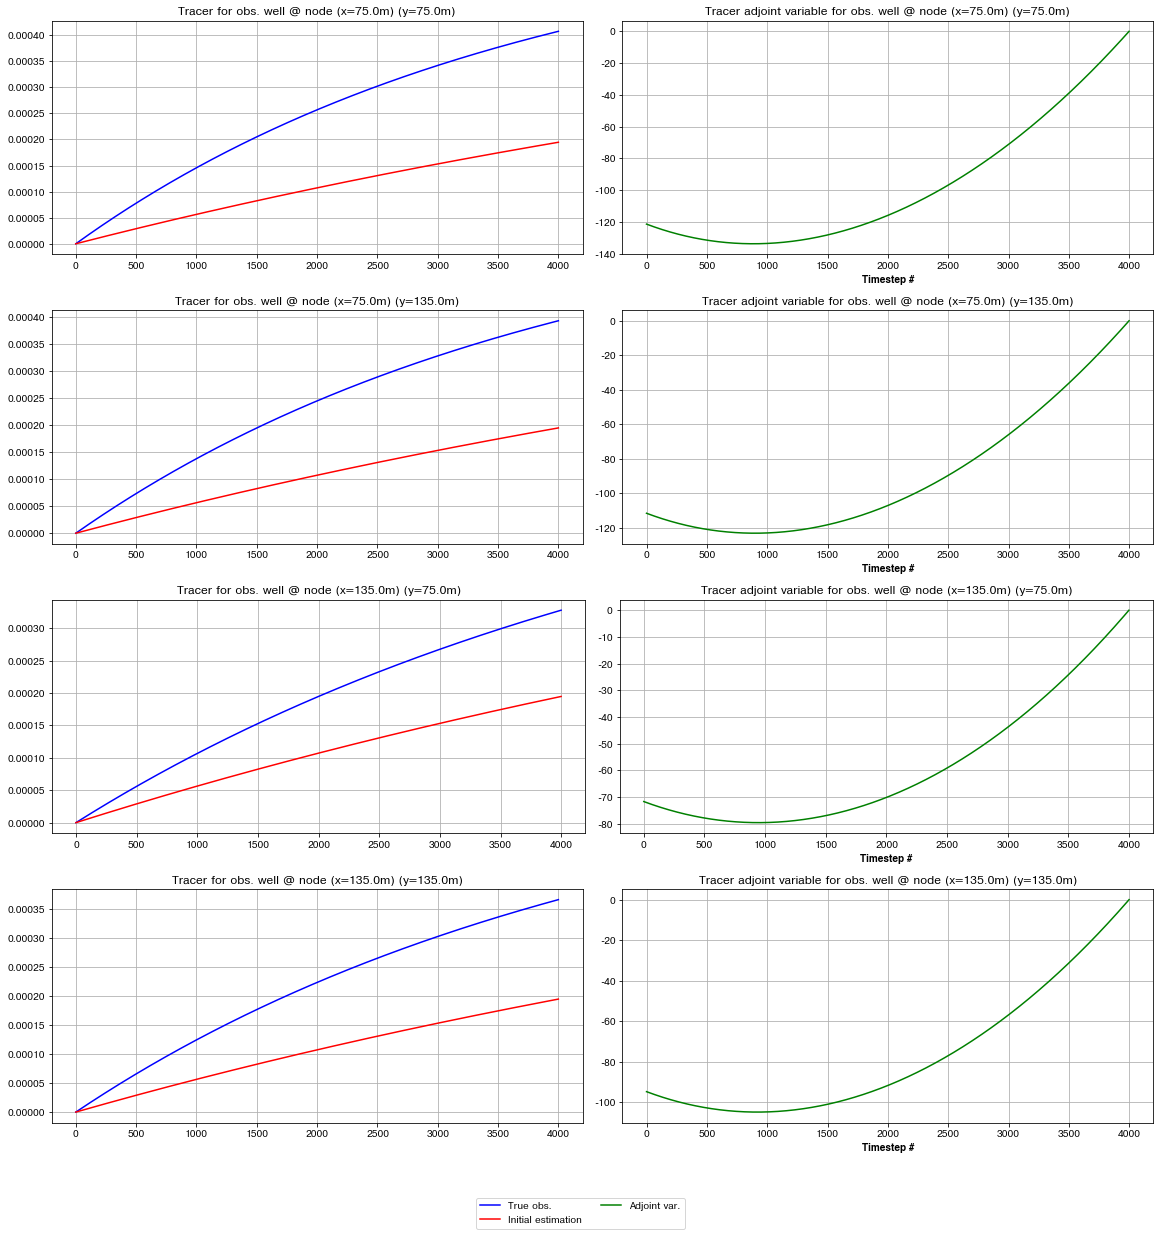

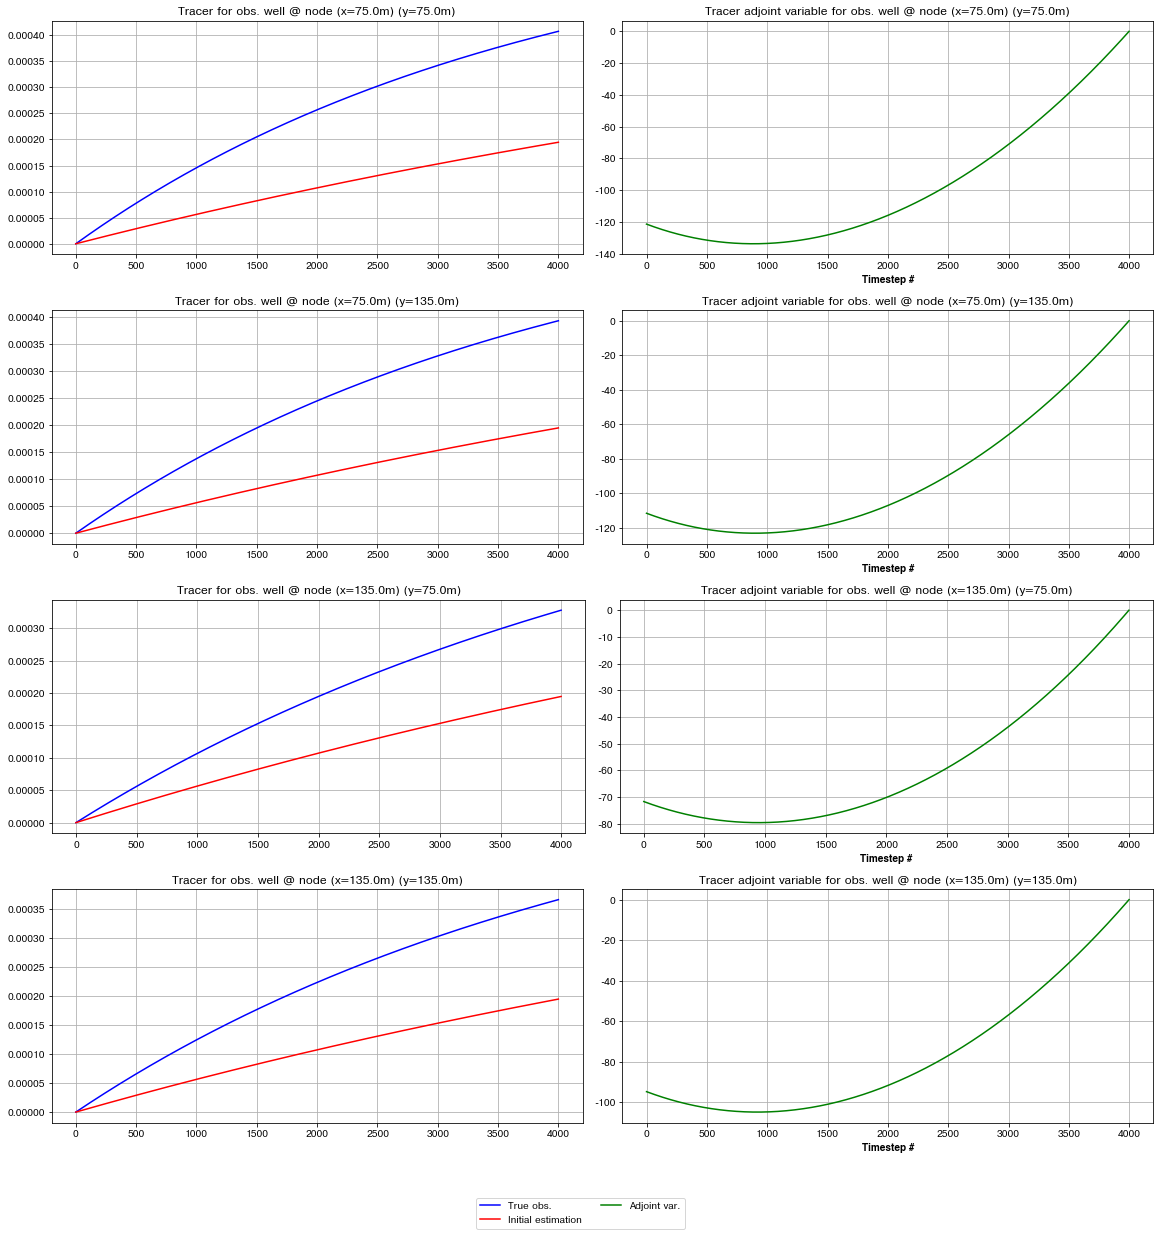

In [ ]:
plotter = StateVariableSlicePlotter(nb_obs_loc=4, nb_obs_type=2)

for i, (coords, obs) in enumerate(observables.items()):
    ix = coords[0]
    jx = coords[1]
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node (x={x}m) (y={y}m)"

    plotter.plot_state(
        row_id=i,
        obs_well_name=obs_well_name,
        data={
            "Tracer": {
                "True obs.": (
                    executor.rt_solver.inverse_model.observables[i].values,
                    {"c": "b"},
                ),
                "Initial estimation": (
                    executor.rt_solver.model.fwd_conc[ix, jx, :],
                    {"c": "r"},
                ),
            },
            "Tracer adjoint variable": {
                "Adjoint var.": (
                    executor.rt_solver.inverse_model.adj_conc[ix, jx, :],
                    {"c": "g"},
                ),
            },
        },
    )
plotter.add_fig_legend(ncol=2)

### First inversion run

In [ ]:
# Create an executor
executor = InversionExecutor(copy.copy(model_estimate))

param = AdjustableParameter(
    name=ParameterName.INITIAL_GRADE,
    lbounds=1e-3,
    ubounds=2e-2,
)

observables = {}
for i, coords in enumerate(obs_grid_locations):
    ix = coords[0]
    jx = coords[1]
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node (x={x}m) (y={y}m)"

    vals = model_reference.tr_model.conc[ix, jx, :]
    timesteps = np.arange(vals.shape[0])

    observables[coords] = Observable(
        state_variable="tracer",
        location=(slice(ix, ix + 1, 1), slice(jx, jx + 1, 1)),
        timesteps=timesteps,
        values=model_reference.tr_model.conc[ix, jx, :],
    )

executor.run_inversion(
    param,
    list(observables.values()),
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 30, "maxiter": 30, "ftol": 1e-6, "gtol": 1e-6},
    is_check_gradient=False,
)

     * ==================================================
     * Grid dimensions nx                    : 21
     * Increment in x (m)                    : 10.0
     * x-positions of the production well #1 : 12
     * x-positions of the production well #2 : 12
     * x-positions of the production well #3 : 12
     * Labelsize                             : 14
     * Increment in time (dt) in s           : 400.0
     * Simulation duration [days]            : 18.52
     * ==================================================
Entering optimization loop: 1


Let's plot the results: evolution of the parameter, the gradient, the objective function.

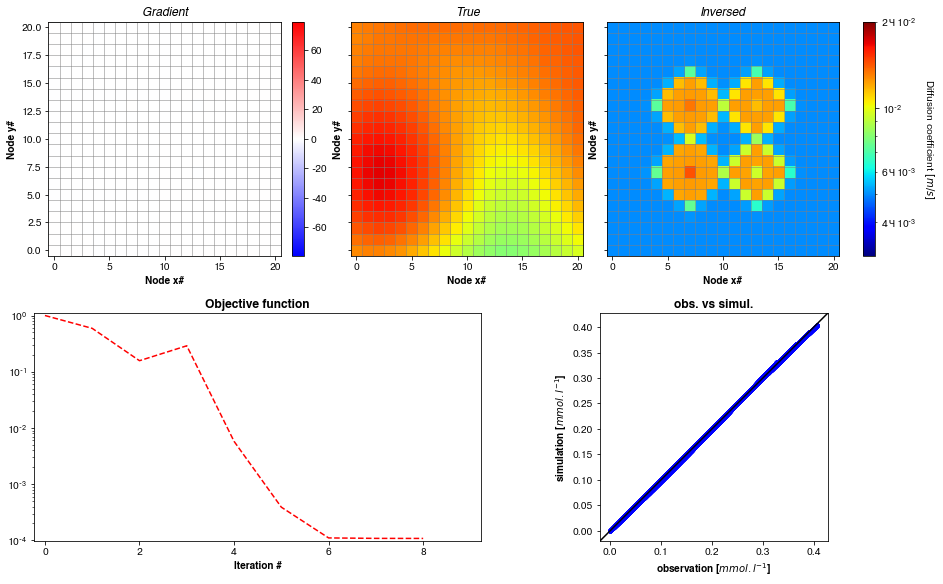

In [ ]:
adjoint_gradients = executor.rt_solver.get_gridded_gradients(
    ParameterName.INITIAL_GRADE, is_adjoint=True
)

anim_res_plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (13, 8)},
    subfigs_params={"nrows": 2, "ncols": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharex=True, sharey=True),
        "fig1": dict(mosaic=[["ax2-1", "ax2-2"]]),
    },
)

# 1 frame per solver iteration
nb_frames: int = len(executor.rt_solver.inverse_model.loss_scaled_history)

# 1) Gradient evolution
anim_res_plotter.plot_2d_animated_field(
    ax_names=["ax1-1"],
    data={
        "Gradient": adjoint_gradients,
    },
    is_add_grid=True,
    # title="Gradient",
    xlabel="Node x#",
    ylabel="Node y#",
    nb_frames=nb_frames,
    is_symmetric_cbar=True,
)

# 2) Parameter evolution
anim_res_plotter.plot_2d_animated_field(
    ax_names=["ax1-2", "ax1-3"],
    data={
        "True": np.repeat(
            model_reference.s_init.reshape(nx, ny, -1), nb_frames, axis=2
        ),
        "inverted": np.transpose(np.array(param.archived_values), axes=[1, 2, 0]),
    },
    is_add_grid=True,
    # title="Gradient",
    xlabel="Node x#",
    ylabel="Node y#",
    nb_frames=nb_frames,
    cbar_title="Diffusion coefficient $[m/s]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "norm": LogNorm()},
)

# 3) Objective function
vals = executor.rt_solver.inverse_model.loss_scaled_history
obj_fun_vals = np.full((nb_frames, len(vals)), fill_value=np.nan)
for i in range(len(vals)):
    obj_fun_vals[i, : i + 1] = vals[: i + 1]

anim_res_plotter.plot_1d_animated_field(
    ax_name="ax2-1",
    nb_frames=nb_frames,
    data={
        "Obj fun": {"data": obj_fun_vals.T, "kwargs": {"c": "r", "linestyle": "--"}},
    },
    title="Objective function",
    xlabel="Iteration #",
)
anim_res_plotter.ax_dict["ax2-1"].set_yscale("log")
# grad_plotter.add_fig_legend(ncol=2)
# grad_plotter.fig

# 4) Observation vs predicted values
anim_res_plotter.plot_observed_vs_simulated(
    ax_name="ax2-2",
    obs_vector=executor.rt_solver.inverse_model.get_obs_values_as_1d_vector() * 1000,
    pred_vector=executor.rt_solver.get_results_matching_obs_vector() * 1000,
    # pred_vector_initial=model_estimate.get_results_matching_obs_vector() * 1000,
    unit="$mmol.l^{-1}$",
)

anim_res_plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname = fig_save_path.joinpath("m_j_g_animation..html")
writer = HTMLWriter(fps=2)
writer.frame_format = "svg"  # Ensure svg format
anim_res_plotter.animation.save(fname, writer=writer)
# plotter.animation.save(fname_gif, writer='pillow', fps=5)

# Display the animation
HTML(fname.read_text())

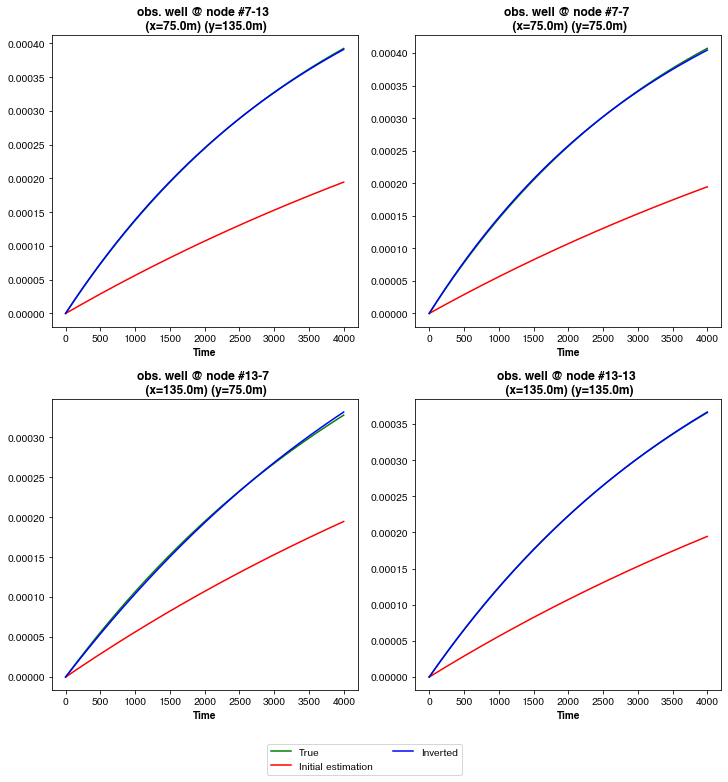

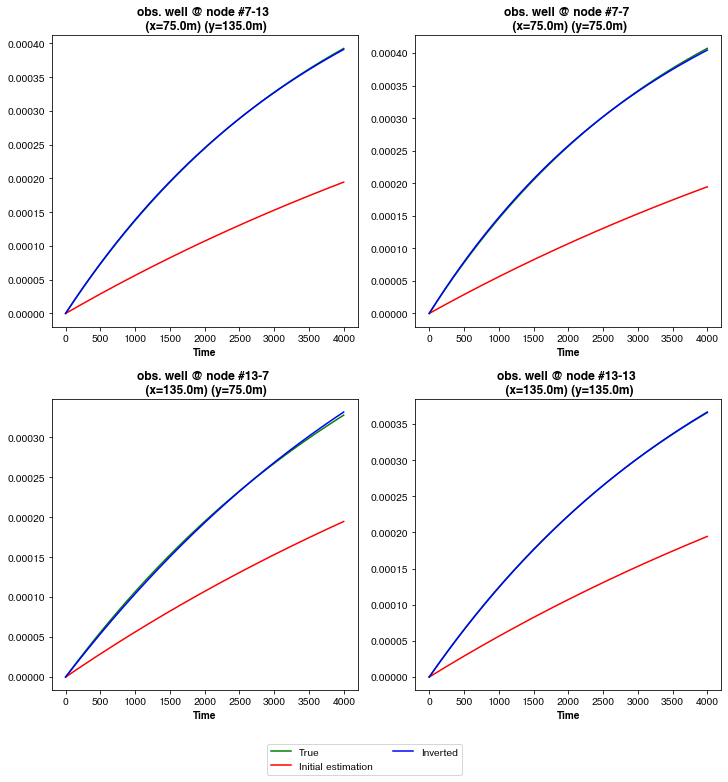

In [ ]:
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subfigs_params={
        "nrows": max([elt[0] for elt in obs_plot_locations]),
        "ncols": max([elt[1] for elt in obs_plot_locations]),
    },
)

# Static plot
for (ix, jx), (row_id, col_id) in zip(obs_grid_locations, obs_plot_locations):
    x = (ix + 0.5) * model_reference.dx
    y = (jx + 0.5) * model_reference.dy
    obs_well_name = f"obs. well @ node #{ix}-{jx} \n (x={x}m) (y={y}m)"

    plotter.plot_1d_field(
        ax_name=f"ax{row_id}-{col_id}",
        title=obs_well_name,
        data={
            "True": {
                "data": model_reference.tr_model.conc[ix, jx, :],
                "kwargs": {"c": "g"},
            },
            "Initial estimation": {
                "data": model_estimate.tr_model.conc[ix, jx, :],
                "kwargs": {"c": "r"},
            },
            "Inverted": {
                "data": executor.rt_solver.model.fwd_conc[ix, jx, :],
                "kwargs": {"c": "b"},
            },
        },
        xlabel="Time",
    )
plotter.add_fig_legend(ncol=2)
plotter.fig

# Impact of the regularization and smoothing

We create three different models:
- The first without regularization
- The second with a Tikhonov regularization
- The third with a TV regularization
- The fourth with gaussian smoothing
- The fifth with gaussian smoothing + Tikhonov reg.

In [ ]:
param_no_reg = AdjustableParameter(
    name=ParameterName.INITIAL_GRADE,
    lbounds=1e-3,
    ubounds=2e-2,
)

param_reg_tikhonov = AdjustableParameter(
    name=ParameterName.INITIAL_GRADE,
    lbounds=1e-3,
    ubounds=2e-2,
    regularizators=[
        TikhonovRegularizator(
            model_reference.dx, model_reference.dy, axis=0, is_preconditioned=True
        ),
        TikhonovRegularizator(
            model_reference.dx, model_reference.dy, axis=1, is_preconditioned=True
        ),
    ],
)

param_reg_tv = AdjustableParameter(
    name=ParameterName.INITIAL_GRADE,
    lbounds=1e-3,
    ubounds=2e-2,
    regularizators=[
        TVRegularizator(
            model_reference.dx, model_reference.dy, axis=0, is_preconditioned=True
        ),
        TVRegularizator(
            model_reference.dx, model_reference.dy, axis=1, is_preconditioned=True
        ),
    ],
)

sigmas = [[1.5, 1.5], [1.5, 1.5], [1.0, 1.0], [0.5, 0.5], [0.25, 0.25]]

param_smoother = AdjustableParameter(
    name=ParameterName.INITIAL_GRADE,
    lbounds=1e-3,
    ubounds=2e-2,
    filters=[GaussianFilter(sigmas=sigmas)],
)

param_smoother_reg_tikhonov = AdjustableParameter(
    name=ParameterName.INITIAL_GRADE,
    lbounds=1e-3,
    ubounds=2e-2,
    regularizators=[
        TikhonovRegularizator(
            model_reference.dx, model_reference.dy, axis=0, is_preconditioned=True
        ),
        TikhonovRegularizator(
            model_reference.dx, model_reference.dy, axis=1, is_preconditioned=True
        ),
    ],
    filters=[GaussianFilter(sigmas=sigmas)],
)

In [ ]:
# Common arguments for solvers
common_kwargs = dict(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 30, "maxiter": 30, "ftol": 1e-8, "gtol": 1e-8},
    max_optimization_round_nb=3,
    is_check_gradient=False,
)

# Running the inversion without regularization
executor_no_reg = InversionExecutor(model_estimate)
executor_no_reg.run_inversion(param_no_reg, list(observables.values()), **common_kwargs)

# Running the inversion with tikhonov regularization
executor_tikhonov = InversionExecutor(model_estimate)
executor_tikhonov.run_inversion(
    param_reg_tikhonov, list(observables.values()), **common_kwargs
)

# Running the inversion with total variation regularization
executor_tv = InversionExecutor(model_estimate)
executor_tv.run_inversion(param_reg_tv, list(observables.values()), **common_kwargs)

# Running the inversion with a smoother
executor_smoother = InversionExecutor(model_estimate)
executor_smoother.run_inversion(
    param_smoother, list(observables.values()), **common_kwargs
)

# Running the inversion with a smoother + tikhonov regularization
executor_smoother_tikhonov = InversionExecutor(model_estimate)
executor_smoother_tikhonov.run_inversion(
    param_smoother_reg_tikhonov, list(observables.values()), **common_kwargs
)

     * ==================================================
     * Grid dimensions nx                    : 21
     * Increment in x (m)                    : 10.0
     * x-positions of the production well #1 : 12
     * x-positions of the production well #2 : 12
     * x-positions of the production well #3 : 12
     * Labelsize                             : 14
     * Increment in time (dt) in s           : 400.0
     * Simulation duration [days]            : 18.52
     * ==================================================
Entering optimization loop: 1
     * ==================================================
     * Grid dimensions nx                    : 21
     * Increment in x (m)                    : 10.0
     * x-positions of the production well #1 : 12
     * x-positions of the production well #2 : 12
     * x-positions of the production well #3 : 12
     * Labelsize                             : 14
     * Increment in time (dt) in s           : 400.0
     * Simulation duration [days]

Let's see the results in term of inverted parameter.

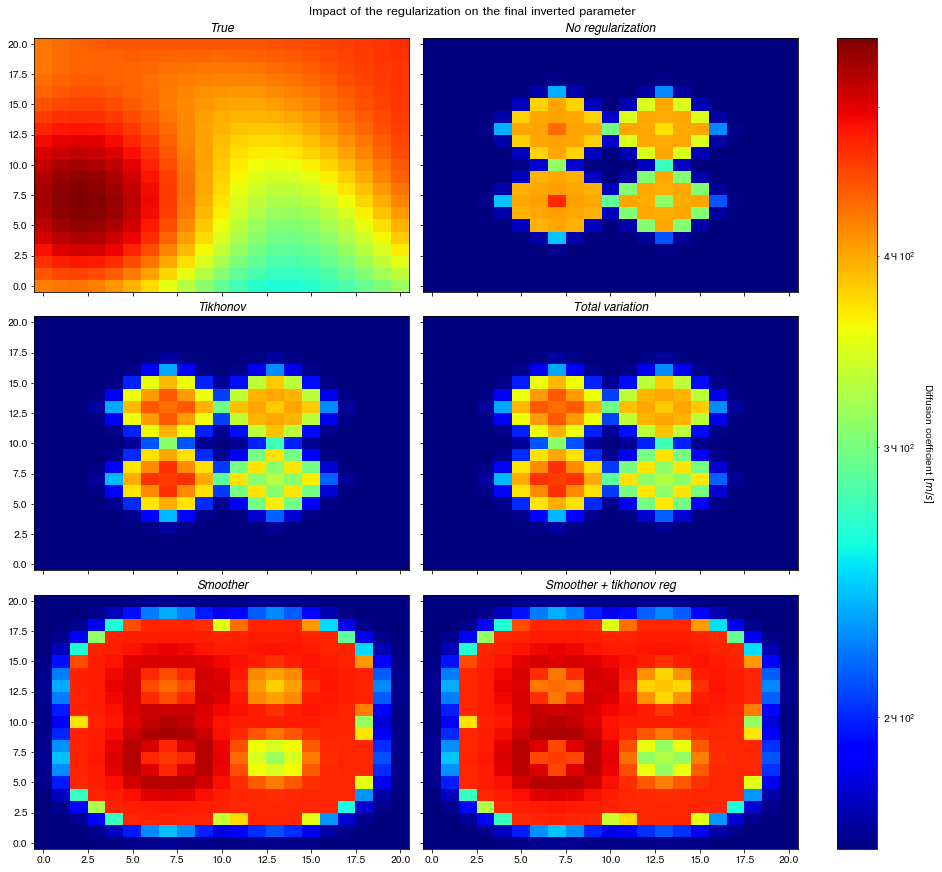

In [ ]:
# Here comes the python code
plotter = FieldPlotter(
    fig_params={"constrained_layout": True, "figsize": (13, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"], ["ax3-1", "ax3-2"]],
            sharex=True,
            sharey=True,
        ),
    },
)

# Get the parameter to plot
plotter.plot_2d_field(
    ax_names=["ax1-1", "ax1-2", "ax2-1", "ax2-2", "ax3-1", "ax3-2"],
    data={
        "True": model_reference.s_init / conv_u * 1000,
        "No regularization": param_no_reg.archived_values[-1] / conv_u * 1000,
        "Tikhonov": param_reg_tikhonov.archived_values[-1] / conv_u * 1000,
        "Total variation": param_reg_tv.archived_values[-1] / conv_u * 1000,
        "Smoother": param_smoother.archived_values[-1] / conv_u * 1000,
        "Smoother + tikhonov reg": param_smoother_reg_tikhonov.archived_values[-1]
        / conv_u
        * 1000,
    },
    cbar_title="Diffusion coefficient $[m/s]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "norm": LogNorm()},
    # title="No regularization",
    # ylabel="Diffusivity (m/s)",
    # xlabel="Nodes #"
)

plotter.fig.suptitle("Impact of the regularization on the final inverted parameter")
plotter.fig